In [22]:
!pip install tensorflow
!pip install scikit-learn
import tensorflow
import tensorflow.keras as keras
from keras.models import Sequential, load_model
from keras.layers import Reshape, Permute, GRU
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, classification_report, roc_auc_score, average_precision_score
from keras.utils import set_random_seed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 2.5 MB/s eta 0:00:0000:0100:01


In [2]:
# load train, validation and test data in UCloud

X_train = np.load('X_train.npy')
X_val = np.load('X_val.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')

# load data in Colab
"""
from google.colab import drive

# mount to Google Drive 
drive.mount("/content/drive")

# save the most common part of file path
root_path = "/content/drive/My Drive/Audio_Mood_Classification"

file_names = ['X_train_mfcc30s.npy',
              'X_val_mfcc30s.npy',
              'X_test_mfcc30s.npy',
              'y_train_mfcc30s.npy',
              'y_val_mfcc30s.npy',
              'y_test_mfcc30s.npy']

folder = "train_test_data/mfcc30s"

for name in file_names:
    file_path = os.path.join(root_path, folder, name)
    var_name = name.split('.')[0]
    globals()[var_name] = np.load(file_path)
"""

'\nfrom google.colab import drive\n\n# mount to Google Drive \ndrive.mount("/content/drive")\n\n# save the most common part of file path\nroot_path = "/content/drive/My Drive/Audio_Mood_Classification"\n\nfile_names = [\'X_train_mfcc30s.npy\',\n              \'X_val_mfcc30s.npy\',\n              \'X_test_mfcc30s.npy\',\n              \'y_train_mfcc30s.npy\',\n              \'y_val_mfcc30s.npy\',\n              \'y_test_mfcc30s.npy\']\n\nfolder = "train_test_data/mfcc30s"\n\nfor name in file_names:\n    file_path = os.path.join(root_path, folder, name)\n    var_name = name.split(\'.\')[0]\n    globals()[var_name] = np.load(file_path)\n'

In [3]:
print('X_train: \n' + str(X_train.shape) + '\n')
print('X_val: \n' + str(X_val.shape) + '\n')
print('X_test: \n' + str(X_test.shape) + '\n')
print('y_train: \n' + str(y_train.shape) + '\n')
print('y_val: \n' + str(y_val.shape) + '\n')
print('y_test: \n' + str(y_test.shape) + '\n')

X_train: 
(4239, 1292, 20, 1)

X_val: 
(1413, 1292, 20, 1)

X_test: 
(1413, 1292, 20, 1)

y_train: 
(4239, 10)

y_val: 
(1413, 10)

y_test: 
(1413, 10)



In [23]:
# define input shape and optimizer and epochs
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

optimizer = keras.optimizers.Adam(learning_rate= 0.001)

epochs = 30

# set seed
keras.utils.set_random_seed(17)

# define standard functions used for all models

def compiler(cnn, optimizer=optimizer):
  """
  compiles the model
  by default, the Adam optimizer from keras is used. In cases where this does not work, the optimizer can be chosen differently, e.g. legacy.Adam 
  """
  cnn.compile(optimizer=optimizer,
             loss = keras.losses.binary_crossentropy,
             metrics = [keras.metrics.AUC(name="auc",
                                          curve="ROC",
                                          thresholds=[0.5]*10,
                                          multi_label=True),
                        keras.metrics.Precision(name="precision",
                                               thresholds=[0.5]*10),
                        keras.metrics.Recall(name="recall",
                                             thresholds=[0.5]*10)])

def fit_model(cnn):
  """
  fits the compiled model to the data
  """
  history = cnn.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    batch_size=32, epochs = epochs)
  return history

def plot_training(history):
  """
  prints plots for the training development of the loss and the AUC
  """
  # retrieve time series from history
  auc = history.history['auc']
  val_auc = history.history['val_auc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  # Plot the figure for Training and Validation Accuracy
  plt.plot(epochs_range, auc, label='Training AUC')
  plt.plot(epochs_range, val_auc, label='Validation AUC')
  plt.legend(loc='lower right')
  plt.title('Training and Validation AUC')
  plt.show()

  # Plot the figure for Training and Validation Loss
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

def get_validation_metrics(history):
  """
  retrieve the key evaluation metrics from the model history
  """
  val_auc = history.history['val_auc']
  val_precision = history.history['val_precision']
  val_recall = history.history['val_recall']
    
  return val_auc, val_precision, val_recall

# optimize thresholds on the validation set maximizing macro f1 score
def optimize_thresholds(y_val, y_pred_val):
    thresholds = []
    
    for i in range(y_val.shape[1]):
        best_threshold = 0
        best_f1 = 0
        
        # Vary threshold from 0 to 1 with a small step size
        for threshold in np.arange(0.1, 1.0, 0.05):
            y_pred_thresholded = (y_pred_val[:, i] >= threshold).astype(int)
            f1 = f1_score(y_val[:, i], y_pred_thresholded)
            
            # Update best threshold if F1-score is higher
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        thresholds.append(best_threshold)
    
    return thresholds


def get_classification_report(cnn):
  """
  recalculates the probebility output from the model to labels by finding the optimal threshold value for every class
  prints a classification report with all relevant evaluation metrics for the evaluation set
  """
  y_pred_val = cnn.predict(X_val)
  thresholds = optimize_thresholds(y_val, y_pred_val)
  y_pred_labels = np.where(y_pred_val >= thresholds, 1, 0)
  report = classification_report(
            y_val,
            y_pred_labels,
            output_dict=False,
            target_names=['inspiring', 'energetic', 'happy', 'sad', 'motivational', 'relaxing', 'uplifting', 'calm', 'love','hopeful'],
            zero_division=1
            )

  print(report)

In [5]:

# CNN 1: Shallow CNN
cnn1 = keras.models.Sequential([
    # 1st conv layer
    keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape, activity_regularizer=regularizers.L2(5e-4)),
    keras.layers.MaxPool2D((3, 3), strides = (2, 2), padding = 'same'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    # 2nd conv layer
    keras.layers.Conv2D(64, (3, 3), activation='relu',  activity_regularizer=regularizers.L2(5e-4)),
    keras.layers.MaxPool2D((2, 2), strides=(3, 2), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    # flatten
    keras.layers.Flatten(),

    # fully connected layer
    keras.layers.Dense(128, activation='relu',  activity_regularizer=regularizers.L2(5e-4)),
    keras.layers.Dropout(0.5),
    
    # output layer
    keras.layers.Dense(10, activation = 'sigmoid', name='output')
])

In [6]:
# compile model
compiler(cnn1)

# train model
cnn1_history = fit_model(cnn1)

Epoch 1/30
133/133 [==============================] - 24s 170ms/step - loss: 1.4197 - auc: 0.5047 - precision: 0.1881 - recall: 0.0872 - val_loss: 0.4270 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
133/133 [==============================] - 22s 162ms/step - loss: 0.3932 - auc: 0.5011 - precision: 0.2778 - recall: 0.0075 - val_loss: 0.4102 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
133/133 [==============================] - 21s 159ms/step - loss: 0.3804 - auc: 0.5019 - precision: 0.5132 - recall: 0.0073 - val_loss: 0.3854 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
133/133 [==============================] - 21s 161ms/step - loss: 0.3736 - auc: 0.5037 - precision: 0.5035 - recall: 0.0134 - val_loss: 0.3659 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
133/133 [==============================] - 21s 161ms/step - loss: 0.3691 - auc: 0.5027 - 

In [12]:
print("input shape: " + str(input_shape))
cnn1.summary()

input shape: (1292, 20, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1290, 18, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 645, 9, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 645, 9, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 645, 9, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 643, 7, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling 

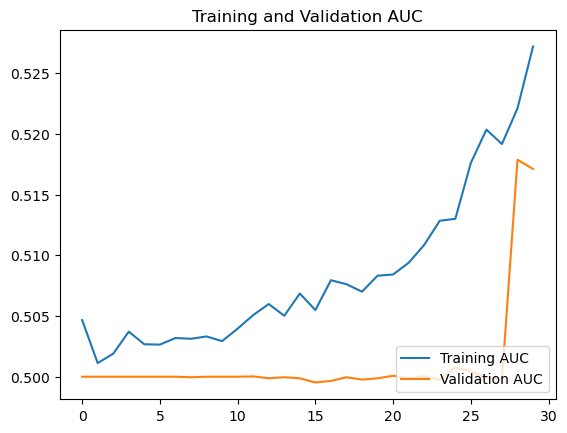

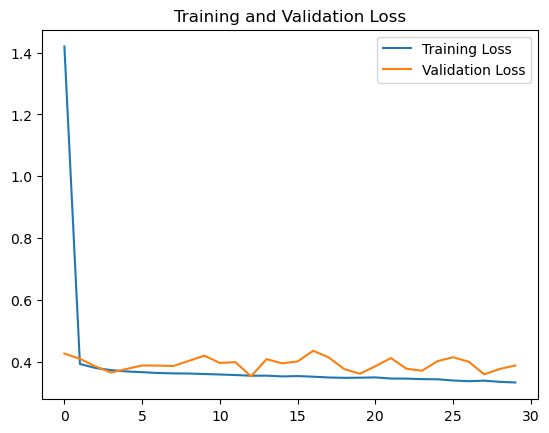

In [9]:
# plot training
plot_training(cnn1_history)

In [10]:
# compute final training evaluation metrics
cnn1_evaluation = cnn1.evaluate(x = X_val, y= y_val)

45/45 [==============================] - 1s 24ms/step - loss: 0.3885 - auc: 0.5171 - precision: 0.3467 - recall: 0.0851


In [24]:
# print the evaluation metrics with optimized thresholds
get_classification_report(cnn1)

45/45 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

   inspiring       0.06      0.19      0.09        83
   energetic       0.37      0.39      0.38       286
       happy       0.32      0.62      0.42       334
         sad       0.08      0.03      0.04        40
motivational       0.12      0.86      0.21       161
    relaxing       0.13      0.94      0.23       186
   uplifting       0.07      0.29      0.11       100
        calm       0.35      0.57      0.43       254
        love       0.15      0.66      0.25       141
     hopeful       0.10      0.22      0.14       142

   micro avg       0.17      0.55      0.26      1727
   macro avg       0.17      0.48      0.23      1727
weighted avg       0.23      0.55      0.30      1727
 samples avg       0.18      0.56      0.25      1727



In [ ]:
# CNN 2: deep CNN inspired by Yi et al 2020
cnn2 = keras.models.Sequential([
    # 1st conv layer
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu", input_shape = input_shape),
    keras.layers.MaxPool2D((2,2), strides=(2,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    # 2nd conv layer
    keras.layers.Conv2D(64, kernel_size=3, activation="relu"),
    keras.layers.MaxPool2D((2,2), strides=(2,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    # 3rd conv layer
    keras.layers.Conv2D(128, kernel_size=3,  activation="relu"),
    keras.layers.MaxPool2D((2,2), strides=(2,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    # 4th conv layer
    keras.layers.Conv2D(256, kernel_size=3, activation="relu"),
    keras.layers.MaxPool2D((2,2), strides=(2,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    # 5th conv layer
    keras.layers.Conv2D(512, kernel_size=3, activation="relu"),
    keras.layers.MaxPool2D((2,2), strides=(2,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    # 6th conv layer
    keras.layers.Conv2D(256, kernel_size=3, activation="relu"),
    keras.layers.MaxPool2D((2,2), strides=(2,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    # Flatten
    keras.layers.Flatten(),
    
    # Dense Layer
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.1),

    # Output layer
    keras.layers.Dense(10, activation ='sigmoid', name='output')
])

# adjust all parameters but Conv layer numbers
# do we need some special data structure in the flatten step?

In [ ]:
# compile model
compiler(cnn2, optimizer=keras.optimizers.legacy.Adam(learning_rate= 0.001))

# train model
cnn2_history = fit_model(cnn2)

Epoch 1/30
2/2 [==============================] - 14s 4s/step - loss: 0.9599 - auc: 0.4554 - precision: 0.1070 - recall: 0.3448 - val_loss: 0.6434 - val_auc: 0.6046 - val_precision: 0.3750 - val_recall: 0.3000
Epoch 2/30
2/2 [==============================] - 11s 4s/step - loss: 0.6856 - auc: 0.6195 - precision: 0.1771 - recall: 0.2931 - val_loss: 0.5846 - val_auc: 0.6323 - val_precision: 0.0625 - val_recall: 0.0500
Epoch 3/30
2/2 [==============================] - 15s 4s/step - loss: 0.4524 - auc: 0.7475 - precision: 0.2281 - recall: 0.2241 - val_loss: 0.5085 - val_auc: 0.5289 - val_precision: 0.1250 - val_recall: 0.1000
Epoch 4/30
2/2 [==============================] - 15s 5s/step - loss: 0.3911 - auc: 0.8151 - precision: 0.4565 - recall: 0.3621 - val_loss: 0.4851 - val_auc: 0.5209 - val_precision: 0.1250 - val_recall: 0.1000
Epoch 5/30
2/2 [==============================] - 12s 4s/step - loss: 0.3960 - auc: 0.8215 - precision: 0.4500 - recall: 0.3103 - val_loss: 0.4969 - val_auc: 0.

In [ ]:
print("input shape: " + str(input_shape))
cnn2.summary()

input shape: (1292, 20, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1292, 20, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 646, 19, 32)      0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 646, 19, 32)      128       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 646, 19, 32)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 644, 17, 64)       18496     
                                                                 
 max_pooling2d_5 (MaxPoolin

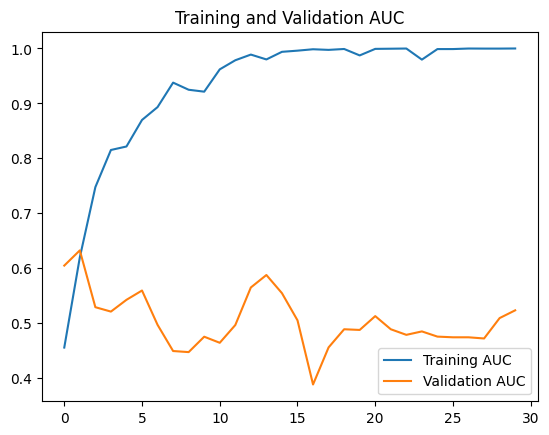

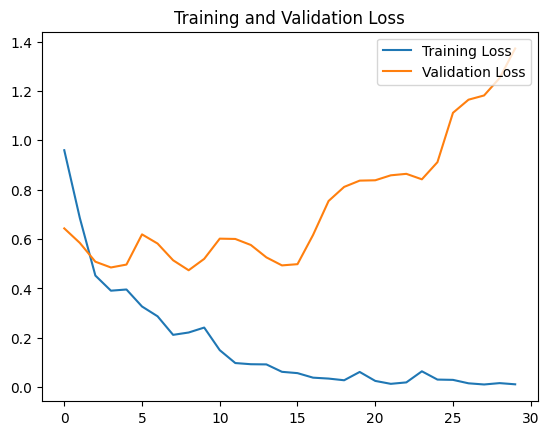

In [ ]:
# plot training
plot_training(cnn2_history)

In [ ]:
# compute final training evaluation metrics
cnn2_evaluation = cnn2.evaluate(x = X_val, y= y_val)

1/1 [==============================] - 1s 834ms/step - loss: 1.3719 - auc: 0.5232 - precision: 0.0000e+00 - recall: 0.0000e+00


In [ ]:
# CNN 3 (FCN-4): FCN structure inspired by Choi et al. 2016
# input shape in paper: (96x1366x1)
# our input shape: (1292x40x1)


cnn3 = keras.models.Sequential([
    
    # 1st conv layer
    keras.layers.Conv2D(128, kernel_size=3, strides=(2,1), padding="same", activation="relu", input_shape=input_shape),
    keras.layers.MaxPool2D((4,1), strides=(2,2), padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    # 2nd conv layer
    keras.layers.Conv2D(384, kernel_size=3, strides = (2,1), activation="relu"),
    keras.layers.MaxPool2D((5,2), strides=(2,2), padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    # 3rd conv layer
    keras.layers.Conv2D(768, kernel_size=(3,1), strides = (2,1), activation="relu"),
    keras.layers.MaxPool2D((6,2), strides=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    # 4th conv layer
    keras.layers.Conv2D(2024, kernel_size=(3,2), strides = (2,1), activation="relu"),
    keras.layers.MaxPool2D((7,1), strides=(2,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    # Flatten (only necessary for dimensionality of output)
    keras.layers.Flatten(),

    # Output layer
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation ='sigmoid', name='output')
])

In [ ]:
# compile model
compiler(cnn3, keras.optimizers.legacy.Adam(learning_rate= 0.001))

# train model
cnn3_history = fit_model(cnn3)

Epoch 1/30
2/2 [==============================] - 7s 2s/step - loss: 1.1072 - auc: 0.5056 - precision: 0.1310 - recall: 0.5172 - val_loss: 0.6889 - val_auc: 0.3555 - val_precision: 0.1167 - val_recall: 0.3500
Epoch 2/30
2/2 [==============================] - 6s 3s/step - loss: 1.0933 - auc: 0.6859 - precision: 0.1787 - recall: 0.7241 - val_loss: 0.6816 - val_auc: 0.4787 - val_precision: 0.1406 - val_recall: 0.4500
Epoch 3/30
2/2 [==============================] - 5s 2s/step - loss: 0.9148 - auc: 0.6533 - precision: 0.1786 - recall: 0.6897 - val_loss: 0.6910 - val_auc: 0.4575 - val_precision: 0.1125 - val_recall: 0.4500
Epoch 4/30
2/2 [==============================] - 5s 2s/step - loss: 0.8437 - auc: 0.6953 - precision: 0.1894 - recall: 0.7414 - val_loss: 0.7029 - val_auc: 0.4412 - val_precision: 0.1277 - val_recall: 0.6000
Epoch 5/30
2/2 [==============================] - 6s 2s/step - loss: 0.7668 - auc: 0.7406 - precision: 0.2019 - recall: 0.7414 - val_loss: 0.7285 - val_auc: 0.3630 

In [ ]:
print("input shape: " + str(input_shape))
cnn3.summary()

input shape: (1292, 20, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 646, 20, 128)      1280      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 323, 10, 128)     0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 323, 10, 128)     512       
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 323, 10, 128)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 161, 8, 384)       442752    
                                                                 
 max_pooling2d_11 (MaxPooli

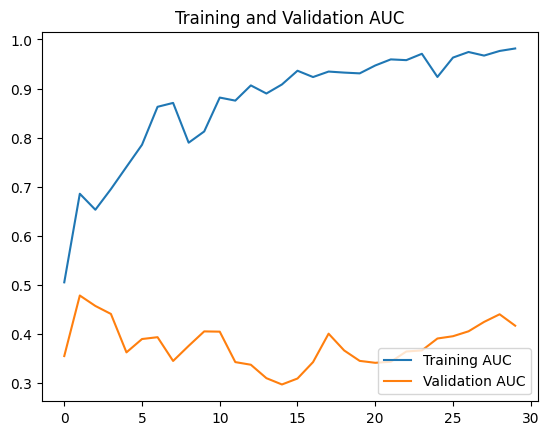

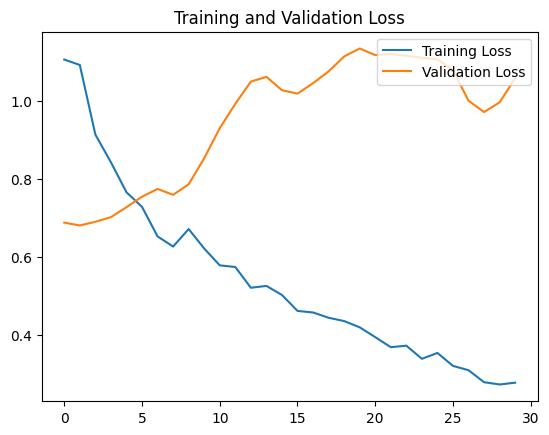

In [ ]:
# plot training
plot_training(cnn3_history)

In [ ]:
# compute final training evaluation metrics
cnn3_evaluation = cnn3.evaluate(x = X_val, y= y_val)

1/1 [==============================] - 1s 550ms/step - loss: 1.0592 - auc: 0.4173 - precision: 0.1000 - recall: 0.3500


In [ ]:
# Using append()
modeldict = {"cnn1": cnn1, "cnn2": cnn2, "cnn3": cnn3}
models = ["cnn1", "cnn2", "cnn3"]
results = pd.DataFrame()
for x in [cnn1_evaluation, cnn2_evaluation, cnn3_evaluation]:
  results = pd.concat([results, pd.Series(x)], axis=1)
results = results.transpose()
results.columns = ["Loss", "AUC", "Precision", "Recall"]
results["Model"] = models
results = results[["Model", "AUC", "Precision", "Recall"]]
results = results.sort_values(by="AUC", ascending=False)
best_model = results.iloc[0,0]
best_model = modeldict[best_model]

print(results)
best_model.evaluate(X_test_mfcc30s, y_test_mfcc30s)

  Model       AUC  Precision  Recall
0  cnn2  0.523214   0.000000    0.00
0  cnn1  0.508214   0.210526    0.20
0  cnn3  0.417321   0.100000    0.35
1/1 [==============================] - 2s 2s/step - loss: 1.2031 - auc: 0.5224 - precision: 0.0000e+00 - recall: 0.0000e+00


[1.2030953168869019, 0.5223978757858276, 0.0, 0.0]